Importing Libraries and Dependencies

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
# Importing necessary packages
import tempfile
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from scripts.balanced_generator import BalancedDatasetGenerator
from scripts.processed_generator import ProcessedDatasetGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse

Initialising model arguments and constants

In [2]:
# Construct the parser and initialise arguments
parser = argparse.ArgumentParser(description='COVID-CNN')

parser.add_argument('--input_size', default=480, type=int, help='Dimensions of the input image')
parser.add_argument('--n_channels', default=3, type=int, help='Number of channels in the image')
parser.add_argument('--train_file', default='train_split.txt', type=str, help='Name of train metadata file')
parser.add_argument('--test_file', default='test_split.txt', type=str, help='Name of test metadata file')
parser.add_argument('--data_dir', default='data', type=str, help='Path to data folder containing datasets')
parser.add_argument('--train_data_dir', default='train', type=str, help='Path to folder containing training dataset')
parser.add_argument('--test_data_dir', default='test', type=str, help='Path to folder containing testing dataset')
parser.add_argument('--num_classes', default=3, type=int, help='Number of classes in the dataset')
parser.add_argument('--num_channels', default=3, type=int, help='Number of channels per image')
parser.add_argument('--epochs', default=15, type=int, help='Number of epochs to train for')
parser.add_argument('--bs', default=8, type=int, help='Batch size')
parser.add_argument('--lr', default=0.0002, type=float, help='Learning rate')
parser.add_argument("-p", "--plot", type=str, default="plots/plot.png", help="Path to save loss/accuracy plot")
parser.add_argument("-mp", "--model_plot", type=str, default="plots/model_plot.png", help="Path to save model's plot")
parser.add_argument("--model_dir", type=str, default="saved_models/", help="Path to save model")
parser.add_argument("--model_name", type=str, default="DenseNet201.h5", help="Name of the model")

args, unknown = parser.parse_known_args()

# Declaring constants
EPOCHS = args.epochs
BS = args.bs
LR = args.lr

Data exploration

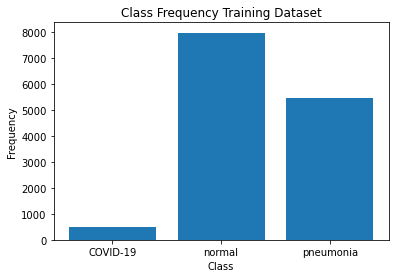

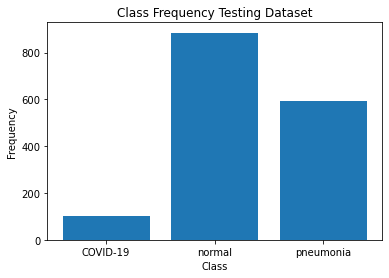

In [3]:
# Reading training dataset csv and extracting labels
df_train = pd.read_csv(args.train_file, sep=' ', header=0, index_col=None)
train_labels = df_train['class']

# Reading testing dataset csv and extracting labels
df_test = pd.read_csv(args.test_file, sep=' ', header=0, index_col=None)
test_labels = df_test['class']

# Extracting unique classes
classes = test_labels.unique()

# Plotting distribution of classes in training dataset
unique, counts = np.unique(train_labels, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency Training Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

# Plotting distribution of classes in testing dataset
unique, counts = np.unique(test_labels, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency Testing Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

Creating the model

In [4]:
# Method to add regularisation
def add_regularization(model, regularizer=regularizers.l2(0.0001)):

    if not isinstance(regularizer, regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # Load the model from the config
    model = model_from_json(model_json)

    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

def create_model():
    # Loading DenseNet201 model trained on imagenet without head
    baseModel = DenseNet201(
        weights="imagenet", include_top=False,
        input_tensor=Input(shape=(args.input_size, args.input_size,
                                  args.n_channels))
    )

    # Constructing the head for classification (to be trained)
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(3, activation="softmax")(headModel)

    # Fixing the weights of base model
    baseModel.trainable = False
    
    #  Adding regularisation
    model = Model(inputs=baseModel.input, outputs=headModel)
    model = add_regularization(model)
    return model

Instantiating data generators to load datasets

In [5]:
test_generator = ProcessedDatasetGenerator(
        data_dir=os.path.join(args.data_dir),
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        is_validation = False,
        data_files=df_test.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n")
)


def get_model(df_trn, df_val):
    model = create_model()
    
    trn_generator = BalancedDatasetGenerator(
        data_dir=os.path.join(args.data_dir),
        data_files=df_trn.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n"),
        batch_size=BS,
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        class_weights = [1.,1.,6.]
    )

    val_generator = ProcessedDatasetGenerator(
        data_dir=os.path.join(args.data_dir),
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        is_validation=True,
        data_files=df_val.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n")
    )

    return model, trn_generator, val_generator

Training the model

In [ ]:
X_train, X_test, _, _ = train_test_split(df_train, df_train['class'], test_size=0.33, random_state=42)

# Getting model and generators fitted on ith fold data
model, train_generator, validation_generator = get_model(X_train, X_test)

# Compiling the model
opt = Adam(learning_rate=LR)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy','AUC'])

train_classes = pd.DataFrame(train_generator.classes)
n_train = len(train_classes[train_classes.isin(['normal', 'pneumonia'])])

val_classes = pd.DataFrame(validation_generator.classes)
n_val = len(val_classes[val_classes.isin(['normal', 'pneumonia'])])

# CREATE CALLBACKS
checkpoint = ModelCheckpoint(args.model_dir+args.model_name, 
                        monitor='val_auc', verbose=1, 
                        save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=2)
callbacks_list = [checkpoint, es]

# Training model
print("[INFO] Training model")
H = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list,
    class_weight={0:1,1:1,2:6},
    use_multiprocessing=True, workers=8)

74842112/74836368 [==============================] - 5s 0us/step
[INFO] Training model
Epoch 1/15
 728/1125 [==================>...........] - ETA: 1:23 - loss: 1.4624 - accuracy: 0.7239 - auc: 0.8811

Plotting training loss and accuracy

In [ ]:
# Plotting training loss and accuracy
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVIDx")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args.plot)

Evaluating the model and generating predictions

In [ ]:
# Predicting on testing data
print("[INFO] Predicting on testing data")

nb_samples = len(df_test[df_test['class'].isin(['normal','pneumonia'])])
# Loading best model
pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
pred = np.argmax(pred, axis=1)

# Getting class label map
temp = []
for i in test_labels:
    temp.append(train_generator.mapping.get(i))

# Printing classification report
print(classification_report(temp, pred, target_names=train_generator.mapping))

In [ ]:
'''
Function to plot confusion matrix
Citation: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
'''
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Printing confusion matrix

In [ ]:
# Generating confusion matrix and calculating: accuracy, sensitivity and specificity
cm = confusion_matrix(temp, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
TN = cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]
FP = cm[1, 0] + cm[2, 0]
specificity = TN / (TN + FP)

# Printing found values
print(cm)
print("Overall Accuracy: {:.4f}".format(acc))
print("COVID Sensitivity: {:.4f}".format(sensitivity))
print("COVID Specificity: {:.4f}".format(specificity))

# Plot normalized confusion matrix
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = list(train_generator.mapping.keys()),
                      title        = "Confusion Matrix")